In [15]:
from pathlib import Path

import pandas as pd
from pandas.errors import EmptyDataError 

import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

In [16]:
# Given parameters:
# 1) detection_dir is the recover-DATE-UNIT_NUM-detect folder
# 2) recording_name is the name of our recording: DATE_TIME.WAV
# 4) det_type can either be 'lf' or 'hf'

# Output:
# The table of detections following the format of RavenPro

def read_detection(detection_dir, recording_name, det_type):
    
    file_name = f"{det_type}_{recording_name}.txt"
    file_path = f"{detection_dir}/{file_name}"
    
    if (Path(file_path).is_file()):
        try:
            df_detection = pd.read_csv(file_path, sep='\t')
        except EmptyDataError:
            print(f"{file_path} is empty")
            
    return df_detection

In [17]:
# These are variables that will help us point to specific folders and files

# Constant DATE is the date of our recovered data that we are extracting detections from
DATE = "20220725"
# Constant UNIT_NUM is the SD CARD # that had been deployed for that session
UNIT_NUM = "010"
# Create recovery folder variable using constants
recover_dir = f"recover-{DATE}-{UNIT_NUM}-detect"
# Constant duration of audio file that we configured into Audiomoth
AUDIO_DUR = pd.DateOffset(minutes=29, seconds=55)

# detection_dir is the recover-DATE-UNIT_NUM-detect folder where our detections are.
detection_dir = f"detections/{recover_dir}"

# Construct path object linked to the directory of files for datetime-parsing
file_dir = Path(detection_dir)
# Extract only the hf-detection files because the datetime information is repeated.
sorted_files = sorted(file_dir.glob('hf_*.txt'))

# We fill the first 3 columns of our dataframe right here using dateutils parser
file_names = []
dates = []
s_times = []
e_times = []
# We fill out the next 2 columns of data regarding the number of LF and HF selections
num_lf_detections = []
num_hf_detections = []

In [18]:
# Iterate through all file paths to extract and store table information for each file
for i, file in enumerate(sorted_files):
    # Extract name of each file as it is
    file_name = file.name
    # Extracting the datetime object from the name of each file
    file_info = datetime.strptime(file_name, "hf_%Y%m%d_%H%M%S.WAV.txt")
    
    # Extract recording name, date, start time, and end time for each file
    recording_name = file_info.strftime("%Y%m%d_%H%M%S.WAV")
    date = file_info.date()
    s_time = file_info.time()
    e_time = (file_info + AUDIO_DUR).time()
    
    # Appending the above properties to be displayed as part of the dataframe
    file_names.append(recording_name)
    dates.append(date)
    s_times.append(s_time)
    e_times.append(e_time)
        
    # Calling read_detection to return the table of selections as a dataframe
    # The detections appear twice: in waveform view and spectrogram view, 
    # so we half the total number of detections
    lf_file_detections = read_detection(detection_dir, recording_name, "lf")
    num_lf_detections.append(lf_file_detections.shape[0]/2)
    hf_file_detections = read_detection(detection_dir, recording_name, 'hf')
    num_hf_detections.append(hf_file_detections.shape[0]/2)

In [19]:
df = pd.DataFrame([file_names, dates, s_times, e_times, num_lf_detections, num_hf_detections], 
                  index=["File Names", "Date", "Start Time (UTC)", "End Time (UTC)", "# of LF detections", "# of HF detections"]).T
df

,File Names,Date,Start Time (UTC),End Time (UTC),# of LF detections,# of HF detections
0,20220723_000000.WAV,2022-07-23,00:00:00,00:29:55,0.0,0.0
1,20220723_003000.WAV,2022-07-23,00:30:00,00:59:55,0.0,0.0
2,20220723_010000.WAV,2022-07-23,01:00:00,01:29:55,0.0,0.0
3,20220723_013000.WAV,2022-07-23,01:30:00,01:59:55,0.0,0.0
4,20220723_020000.WAV,2022-07-23,02:00:00,02:29:55,0.0,0.0
...,...,...,...,...,...,...
91,20220724_213000.WAV,2022-07-24,21:30:00,21:59:55,0.0,0.0
92,20220724_220000.WAV,2022-07-24,22:00:00,22:29:55,0.0,0.0
93,20220724_223000.WAV,2022-07-24,22:30:00,22:59:55,0.0,0.0
94,20220724_230000.WAV,2022-07-24,23:00:00,23:29:55,2.0,0.0


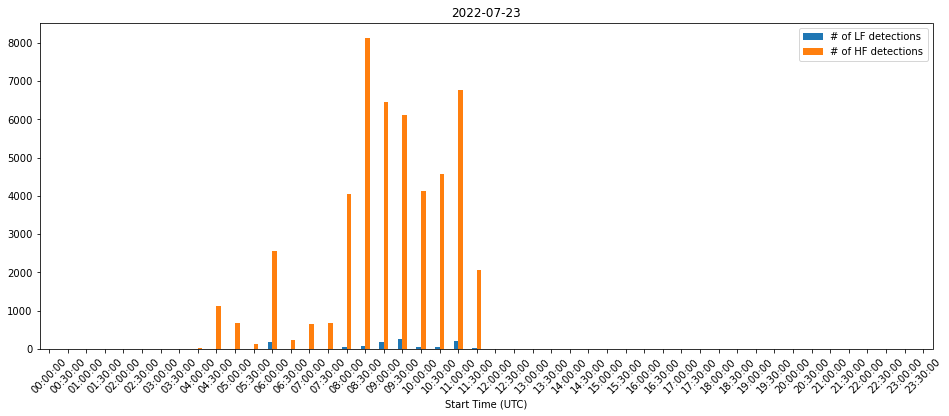

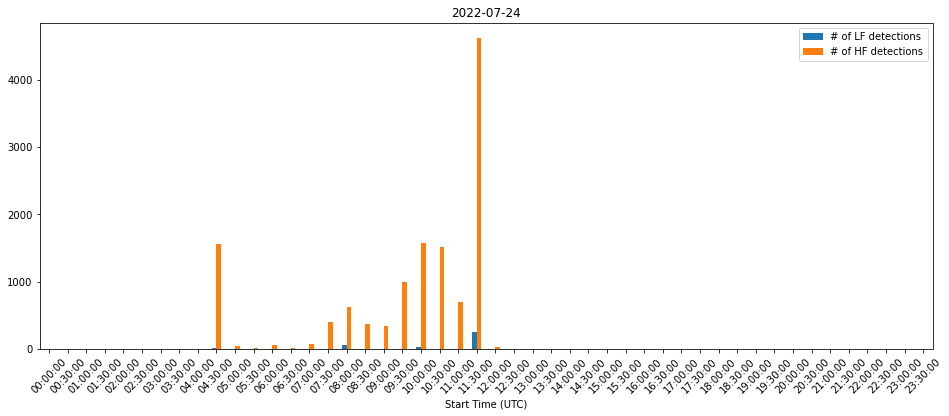

In [60]:
# To plot each day's activity separately, group by rows that have the same date
# We need a list of unique dates from our detection files
unique_dates = df["Date"].unique()

for date in unique_dates:
    day_df = df.loc[df['Date'] == date]
    fig = day_df.plot.bar(x="Start Time (UTC)", title=date, figsize=(16, 6), rot=45).get_figure()
    save_dir = Path(recover_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    save_path = Path(f"{recover_dir}/{date}.png")
    fig.savefig(save_path, facecolor='w')

<AxesSubplot:title={'center':'Total Deployment Session'}, xlabel='Start Time (UTC)'>

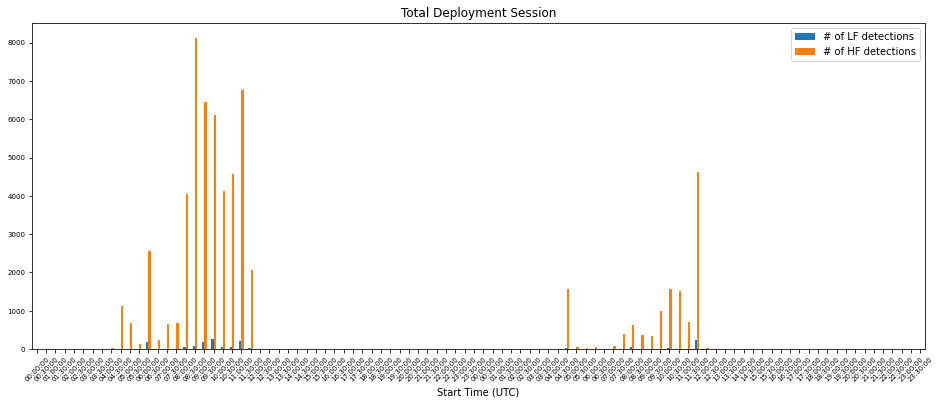

In [84]:
df.plot.bar(x="Start Time (UTC)", title="Total Deployment Session", figsize=(16, 6), fontsize=7, rot=45)